# Deep Q-Network implementation

based on:
https://github.com/yandexdataschool/Practical_RL/tree/master/week4_approx_rl

reference:
https://github.com/BoYanSTKO/Practical_RL-coursera/blob/master/week4_approx/dqn_atari.ipynb


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!apt update 
!apt install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

!pip3 install pyvirtualdisplay piglet gym torch torchvision torchsummary
!pip3 install opencv-python
!pip3 install "gym[atari]"

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from gym.core import ObservationWrapper
from gym.spaces import Box
import gym
from gym.core import Wrapper

# from scipy.misc import imresize
import cv2

# Descriptions of each class and function

* **PrepsocessAtari**: crop, resize, grayscale the image
* **[FrameBuffer](https://github.com/yandexdataschool/Practical_RL/blob/master/week4_approx_rl/framebuffer.py)**: A sym wrapper that output N frames observation

* **make_env()**: apply PreprocessAtari and FrameBuffer to the environment.

After env = make_env(), the env returns obs, reward, done, info;
1. obs: 4x84x84 ndarray
2. reward: float32
3. done: bool

---

* **[ReplayBuffer](https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py)**: store and sample "obs_t, action, reward, obs_tp1, done". 

ReplayBuffer.sample(batch_size) returns:
1. np.array(obses_t):     batch_size x4x84x84
2. np.array(actions):      batch_size
3. np.array(rewards):     batch_size
4. np.array(obses_tp1): batch_size x4x84x84
5. np.array(dones):         batch_size


* **play_and_record()**:    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. Returns sum of rewards over time




In [0]:
class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, (1, self.img_size[0], self.img_size[1]))

    def _observation(self, img):
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size)
        img = img.mean(-1, keepdims=True)  # grayscale
        img = img.astype('float32') / 255.
               
        return img.transpose([2, 0, 1])
      

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

        
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env
  
  
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

      
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    :returns: return sum of rewards over time
    """
    # Make sure that the state is only one batch state, 4x84x84
    # State at the beginning of rollout
    s = env.framebuffer
    R = 0.0
    
    # Play the game for n_steps as per instructions above
    for t in range(n_steps):
        qvalues = agent.get_qvalues(torch.tensor(s).unsqueeze(0))
        action = agent.sample_actions(qvalues).item()
        next_s, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, next_s, done=done)
        if done == True:
            s = env.reset()
        else:
            s = next_s
    return R       
    

In [0]:
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: <class '__main__.PreprocessAtari'> doesn't implement 'observation' method. Maybe it implements deprecated '_observation' method.


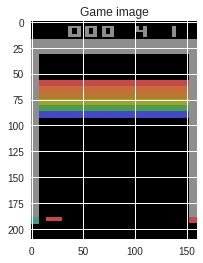

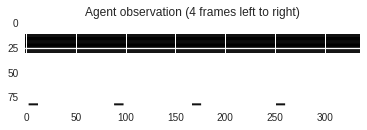

In [0]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([1,0,2]).reshape([obs.shape[1],-1]));

# How the DQN flows

The flow is as follows:

see: https://drive.google.com/file/d/1mJKZEf4laDnPRNSrPesXzlHu36ibImcv/view?usp=sharing


In [0]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        # input obs, output n_actions
        # The network is based on "Mnih, 2015"
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.l1 = nn.Linear(64*7*7, 512)
        self.l2 = nn.Linear(512, n_actions)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size()[0], -1)
        x = self.l1(x)
        x = self.l2(x)
        return x

      
class DQNAgent:
    def __init__(self, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        
        self.dqn = DQN(n_actions)
        self.epsilon = epsilon

    def get_qvalues(self, states):
        """takes agent's observation, returns qvalues. """
        qvalues = self.dqn(states)
        return qvalues
    
    def get_qvalues_for_actions(self, qvalues, actions):
        return qvalues.gather(1, \
                actions.unsqueeze(0).transpose(0, 1)).squeeze()
   
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = torch.tensor(np.random.choice(n_actions, size=batch_size))
        best_actions = qvalues.argmax(1)
        should_explore = torch.tensor(np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])).byte()
        return torch.where(should_explore, random_actions, best_actions)

      
def optimize(current_action_qvalues, optimizer, target_dqn, \
             reward_batch, next_obs_batch, is_done_batch):
    next_qvalues_target = target_dqn.get_qvalues(next_obs_batch)

    # compute state values by taking max over next_qvalues_target for all actions
    next_state_values_target = next_qvalues_target.max(1)[0]
    next_state_values_target = torch.where(torch.tensor(is_done_batch).byte(), \
                                 torch.tensor(reward_batch), \
                                 torch.tensor(next_state_values_target))
    
    # compute Q_reference(s,a) as per formula above.
    reference_qvalues = reward_batch + gamma * next_state_values_target

    # Define loss function for sgd.
    td_loss = (current_action_qvalues - reference_qvalues) ** 2
    td_loss = torch.mean(td_loss)

    optimizer.zero_grad()
    td_loss.backward()
    optimizer.step()
    
    return td_loss.item()
  
      
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            s = torch.tensor(s).unsqueeze(0)
            qvalues = agent.get_qvalues(s)
            action = qvalues.argmax(dim=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

    
def convert_to_tensor(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch):
    obs_batch = torch.tensor(obs_batch)
    act_batch = torch.tensor(act_batch)
    reward_batch = torch.tensor(reward_batch).float()
    next_obs_batch = torch.tensor(next_obs_batch)
    is_done_batch = is_done_batch.astype(np.int)
    return obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch
  

def save_data(folder_path, agent, mean_reward_history, td_loss_history):
    torch.save(policy_agent.dqn.state_dict(), folder_path + 'atari_dqn_state_dict.pt')
    with open(folder_path + 'mean_reward_history.l', 'wb') as f:
        pickle.dump(mean_reward_history, f)
    with open(folder_path + 'td_loss_history.l', 'wb') as f:
        pickle.dump(td_loss_history, f)
        

def load_data(folder_path):
    state_dict = None
    mean_reward_history = []
    td_loss_history = []
    
    state_dict = torch.load(folder_path + 'atari_dqn_state_dict.pt')
    with open(folder_path + 'mean_reward_history.l', 'rb') as f:
        mean_reward_history = pickle.load(f)
    with open(folder_path + 'td_loss_history.l', 'rb') as f:
        td_loss_history = pickle.load(f)
        
    return state_dict, mean_reward_history, td_loss_history
    

In [0]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

gamma = 0.99
policy_agent = DQNAgent(state_dim, n_actions, epsilon=0.2)
target_agent = DQNAgent(state_dim, n_actions)


In [0]:
rl_path = '/content/gdrive/My Drive/AI/Reinforcement_Learning/atari_dqn/new_data/'

# Load the data

In [0]:
state_dict, mean_rw_history, td_loss_history = load_data(rl_path)
policy_agent.dqn.load_state_dict(state_dict)
policy_agent.dqn.eval()
target_agent.dqn.load_state_dict(state_dict)
target_agent.dqn.eval()

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (l1): Linear(in_features=3136, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=4, bias=True)
)

# Main Loop

In [0]:
exp_replay = ReplayBuffer(10**5)
play_and_record(policy_agent, env, exp_replay, n_steps=10000)
optimizer = optim.Adam(policy_agent.dqn.parameters(), lr=1e-4)

In [12]:
for i in trange(int(4e4)):
    
    # play
    play_and_record(policy_agent, env, exp_replay, 10)
    
    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = \
                     convert_to_tensor(*exp_replay.sample(batch_size=64))
    
    q_values = policy_agent.get_qvalues(obs_batch)
    current_action_qvalues = policy_agent.get_qvalues_for_actions(q_values, act_batch)
    loss_t = optimize(current_action_qvalues, optimizer, 
                      target_agent, reward_batch, next_obs_batch, is_done_batch)
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        target_agent.dqn.load_state_dict(policy_agent.dqn.state_dict())
        policy_agent.epsilon = max(policy_agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), policy_agent, n_games=3))
        save_data(rl_path, policy_agent, mean_rw_history, td_loss_history)
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), policy_agent.epsilon))

        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

buffer size = 100000, epsilon = 0.11979
Buffered data was truncated after reaching the output size limit.

In [13]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")

That's good enough for tutorial.


### Video

In [0]:
policy_agent.epsilon=0 # Don't forget to reset epsilon back to previous value if you want to go on training

In [15]:
#record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
sessions = [evaluate(env_monitor, policy_agent, n_games=1) for _ in range(100)]
env_monitor.close()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## More

If you want to play with DQN a bit more, here's a list of things you can try with it:

### Easy:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * You will probably need `tf.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)

### Hard: Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly reduce amount of game sessions you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

There is even more out there - see this [overview article](https://arxiv.org/abs/1710.02298).